# **Workshop: From electrons to phase diagrams**

# Day 2: Validation of the potentials

Once we have the fitted potentials, it is necessary to validate them in order to assess their quality with respect to applications.

In this exercise, we use the fitted potentials and perform some basic calculations.

## Import the fitted potentials for Li-Al (from earlier excercise)

The same directory contains a `helper.py` file which among other things, also contains the necessary specifications of each of the potentials that we will use today. Individual potentials are descrbed in the LAMMPS format as:
```
pot_eam = pd.DataFrame({
    'Name': ['LiAl_eam'],
    'Filename': [["../potentials/AlLi.eam.fs")]],
    'Model': ["EAM"],
    'Species': [['Li', 'Al']],
    'Config': [['pair_style eam/fs\n', 'pair_coeff * * AlLi.eam.fs Li Al\n']]
})

```
A list of such DataFrames describing the potentials is saved in a list called `potentials_list`. We import the list as:

In [1]:
from helper import potentials_list

potentials_list = [potentials_list[0]]

# display the first element in the list
# which is an EAM potential
potentials_list[0]

,Name,Filename,Model,Species,Config
0,LiAl_eam,[/home/minaam.qamar/workshop_POTENTIALS/new_no...,EAM,"[Li, Al]","[pair_style eam/fs\n, pair_coeff * * AlLi.eam...."


### Import other important modules

In [2]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import time
from helper import get_clean_project_name
from pyiron_atomistics import Project
from pyiron import pyiron_to_ase
import pyiron_gpl

# save start time to record runtime of the notebook
time_start =  time.process_time()
time_start

6.366608268

### Create a new project to perform validation calculations

It is useful to create a new project directory for every kind of calculation. Pyiron will automatically create subdirectories for each potential and property we calculate. 

In [3]:
pr = Project("validation_LiAl")

# remove earlier jobs
# pr.remove_jobs(silently=True, recursive=True)

### Define the important pases to consider for validation

We construct a python dictionary `struct_dict` which contains a description of all the important phases that we want to consider for this exercise. The descriptions given in the dictionary will be later used by Pyiron to generate or read the structural configurations for the respective phases.

For unary phases, we provide an initial guess for the lattice parameter and use pyiron to generate the structural prototype.

For binary phases, we provide a phase name and an additional dictionary `fl_dict` which maps the phase name to a `.cif` file saved in a subdirectory. Pyiron will use this information to read the respective configurations from the file.

In [34]:
struct_dict = dict()
struct_dict["Al"] = dict()
struct_dict["Al"]["s_murn"] = ["fcc","bcc"]
struct_dict["Al"]["a"] = 4.04

struct_dict["Li"] = dict()
struct_dict["Li"]["s_murn"] = ["bcc","fcc"]
struct_dict["Li"]["a"] = 3.5




struct_dict["Li2Al2"] = dict()
struct_dict["Li2Al2"]["s_murn"] = ["Li2Al2_cubic"]
# struct_dict["Li2Al2"]["a"] = 3.7

struct_dict["LiAl3"] = dict()
struct_dict["LiAl3"]["s_murn"] = ["LiAl3_tetragonal"]
# struct_dict["LiAl3"]["a"] = 3.7

struct_dict["LiAl3"] = dict()
struct_dict["LiAl3"]["s_murn"] = ["LiAl3_cubic"]
# struct_dict["LiAl3"]["a"] = 3.7

struct_dict["Li9Al4"] = dict()
struct_dict["Li9Al4"]["s_murn"] = ["Li9Al4_monoclinic"]
# struct_dict["Li9Al4"]["a"] = 3.7

struct_dict["Li3Al2"] = dict()
struct_dict["Li3Al2"]["s_murn"] = ["Li3Al2_trigonal"]
# struct_dict["Li3Al2"]["a"] = 3.7

struct_dict["Li4Al4"] = dict()
struct_dict["Li4Al4"]["s_murn"] = ["Li4Al4_cubic"]

struct_dict

{'Al': {'s_murn': ['fcc', 'bcc'], 'a': 4.04},
 'Li': {'s_murn': ['bcc', 'fcc'], 'a': 3.5},
 'Li2Al2': {'s_murn': ['Li2Al2_cubic']},
 'LiAl3': {'s_murn': ['LiAl3_cubic']},
 'Li9Al4': {'s_murn': ['Li9Al4_monoclinic']},
 'Li3Al2': {'s_murn': ['Li3Al2_trigonal']},
 'Li4Al4': {'s_murn': ['Li4Al4_cubic']}}

a dictionary is described to map the binary phases to their file locations

In [35]:
fl_dict = {"Li2Al2_cubic": "mp_structures/LiAl_mp-1067_primitive.cif",
           "LiAl3_tetragonal":"mp_structures/LiAl3_mp-975906_primitive.cif",
           "LiAl3_cubic":"mp_structures/LiAl3_mp-10890_primitive.cif",
           "Li9Al4_monoclinic":"mp_structures/Li9Al4_mp-568404_primitive.cif",
           "Li3Al2_trigonal":"mp_structures/Al2Li3-6021.cif",
           "Li4Al4_cubic":"mp_structures/LiAl_mp-1079240_primitive.cif"}

### (a) Ground state: E-V curves

Using a series of nested `for` loops, we calculate the murnaghan EV-curves using all three potentials for all the defined structures.

We loop over:
 - All the potentials defined in `potentials_list` and name the project according to the potential
   - All the chemical formulae defined in the keys of `struct_dict`
     - All phases defined for a given chemical formula
     
Within the loops, the first step is to get the structure basis on which we will perform the calculations. 

- For unary phases, we use the pyiron function `pr_pot.create_ase_bulk(compound, crys_structure, a=compound_dict["a"])` 
- For binary structures, we read the basis using `pr.create.structure.ase.read(fl_path)` with the `fl_path` given by `fl_dict` defined earlier.

Once the structure and potential is defined as part of the pr_job, we run two calculations:
- `job_relax` to relax the structure to the ground state
- `murn_job` to calculate the energies in a small volume range around the equilibrium

As the calculations are being performed, the status(s) of each calculation is printed. If a job is already calculated, the calculations are not re-run but rather re-read from the saved data.

In [36]:
for pot in potentials_list:
    with pr.open(get_clean_project_name(pot)) as pr_pot:
        for compound, compound_dict in struct_dict.items():
            for crys_structure in compound_dict["s_murn"]:
                
                # Relax structure
                if crys_structure in ["fcc","bcc"]:
                    basis = pr_pot.create_ase_bulk(compound, crys_structure, a=compound_dict["a"])
                else:
                    basis = pr.create.structure.ase.read(fl_dict[crys_structure])
                job_relax = pr_pot.create_job(pr_pot.job_type.Lammps, f"{compound}_{crys_structure}_relax", delete_existing_job=True)

                job_relax.structure = basis
                job_relax.potential = pot
                job_relax.calc_minimize(pressure=0)
                job_relax.run()
                
                # Murnaghan
                job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, f"ref_job_{compound}_{crys_structure}")
                job_ref.structure = job_relax.get_structure(-1)
                job_ref.potential = pot
                job_ref.calc_minimize()
                
                murn_job = job_ref.create_job(pr_pot.job_type.Murnaghan, f"murn_job_{compound}_{crys_structure}")
                murn_job.input["vol_range"] = 0.1
                murn_job.run()

The job Al_fcc_relax was saved and received the ID: 481


2022-05-30 19:18:40,708 - pyiron_log - WARNING - The job murn_job_Al_fcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Al_bcc_relax was saved and received the ID: 482


2022-05-30 19:18:44,855 - pyiron_log - WARNING - The job murn_job_Al_bcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li_bcc_relax was saved and received the ID: 483


2022-05-30 19:18:49,187 - pyiron_log - WARNING - The job murn_job_Li_bcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li_fcc_relax was saved and received the ID: 484


2022-05-30 19:18:55,198 - pyiron_log - WARNING - The job murn_job_Li_fcc is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li2Al2_Li2Al2_cubic_relax was saved and received the ID: 485


2022-05-30 19:19:00,132 - pyiron_log - WARNING - The job murn_job_Li2Al2_Li2Al2_cubic is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job LiAl3_LiAl3_cubic_relax was saved and received the ID: 486


2022-05-30 19:19:06,418 - pyiron_log - WARNING - The job murn_job_LiAl3_LiAl3_cubic is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li9Al4_Li9Al4_monoclinic_relax was saved and received the ID: 487


2022-05-30 19:19:11,676 - pyiron_log - WARNING - The job murn_job_Li9Al4_Li9Al4_monoclinic is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li3Al2_Li3Al2_trigonal_relax was saved and received the ID: 488


2022-05-30 19:19:14,923 - pyiron_log - WARNING - The job murn_job_Li3Al2_Li3Al2_trigonal is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


The job Li4Al4_Li4Al4_cubic_relax was saved and received the ID: 489
The job murn_job_Li4Al4_Li4Al4_cubic was saved and received the ID: 490
The job murn_job_Li4Al4_Li4Al4_cubic_0_9 was saved and received the ID: 491
The job murn_job_Li4Al4_Li4Al4_cubic_0_92 was saved and received the ID: 492
The job murn_job_Li4Al4_Li4Al4_cubic_0_94 was saved and received the ID: 493
The job murn_job_Li4Al4_Li4Al4_cubic_0_96 was saved and received the ID: 494
The job murn_job_Li4Al4_Li4Al4_cubic_0_98 was saved and received the ID: 495
The job murn_job_Li4Al4_Li4Al4_cubic_1_0 was saved and received the ID: 496
The job murn_job_Li4Al4_Li4Al4_cubic_1_02 was saved and received the ID: 497
The job murn_job_Li4Al4_Li4Al4_cubic_1_04 was saved and received the ID: 498
The job murn_job_Li4Al4_Li4Al4_cubic_1_06 was saved and received the ID: 499
The job murn_job_Li4Al4_Li4Al4_cubic_1_08 was saved and received the ID: 500
The job murn_job_Li4Al4_Li4Al4_cubic_1_1 was saved and received the ID: 501


One can display the technical details of all submitted jobs using `pr.job_table()` below.

In [7]:
# pr.job_table()

In order to get read useful results from the completed calculations (eq_energy, eq_volume, etc), it is useful to define the following functions

In [37]:
# Only work with Murnaghan jobs
def get_only_murn(job_table):
    return (job_table.hamilton == "Murnaghan") & (job_table.status == "finished") 

def get_eq_vol(job_path):
    return job_path["output/equilibrium_volume"]

def get_eq_lp(job_path):
    return np.linalg.norm(job_path["output/structure/cell/cell"][0]) * np.sqrt(2)

def get_eq_bm(job_path):
    return job_path["output/equilibrium_bulk_modulus"]

def get_potential(job_path):
    return job_path.project.path.split("/")[-3]

def get_eq_energy(job_path):
    return job_path["output/equilibrium_energy"]

def get_n_atoms(job_path):
    return len(job_path["output/structure/positions"])

def get_ase_atoms(job_path):
    return pyiron_to_ase(job_path.structure).copy()


def get_potential(job_path):
    return job_path.project.path.split("/")[-2]

def get_crystal_structure(job_path):
    return job_path.job_name.split("_")[-1]

def get_compound(job_path):
    return job_path.job_name.split("_")[-2]

Using the functions defined above, one can now define a `pd.DataFrame` containing all useful results

In [38]:
# Compile data using pyiron tables
table = pr.create_table("table_murn", delete_existing_job=True)
table.convert_to_object = True
table.db_filter_function = get_only_murn
table.add["potential"] = get_potential
table.add["ase_atoms"] = get_ase_atoms
table.add["compound"] = get_compound
table.add["crystal_structure"] = get_crystal_structure
table.add["a"] = get_eq_lp
table.add["eq_vol"] = get_eq_vol
table.add["eq_bm"] = get_eq_bm
table.add["eq_energy"] = get_eq_energy
table.add["n_atoms"] = get_n_atoms
table.run()

data_murn = table.get_dataframe()
data_murn["phase"] = data_murn.compound + "_" + data_murn.crystal_structure
data_murn

The job table_murn was saved and received the ID: 502


Loading and filtering jobs:   0%|          | 0/9 [00:00<?, ?it/s]

Processing jobs:   0%|          | 0/9 [00:00<?, ?it/s]

/home/minaam.qamar/.conda/envs/workshop2/lib/python3.10/site-packages/pyiron_base/table/datamining.py:620: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['potential', 'ase_atoms', 'compound', 'crystal_structure'], dtype='object')]

  self.pyiron_table._df.to_hdf(


,job_id,potential,ase_atoms,compound,crystal_structure,a,eq_vol,eq_bm,eq_energy,n_atoms,phase
0,298,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.039967,16.495612,85.876912,-3.483097,1,Al_fcc
1,311,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,bcc,3.898853,16.147864,48.620841,-3.415312,1,Al_bcc
2,324,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,bcc,4.195477,20.114514,13.690609,-1.757011,1,Li_bcc
3,337,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,fcc,4.253841,19.241330,13.985972,-1.758107,1,Li_fcc
4,350,LiAl_eam,"(Atom('Li', [4.359978178265942, 2.5172345748814804, 1.7799536377360752], index=0), Atom('Li', [6.53996726740165, 3.7758518623203585, 2.669930456604318], index=1), Atom('Al', [-3.964456982410852e-1...",Li2Al2,cubic,6.165940,58.604895,100.347240,-11.074362,4,Li2Al2_cubic
5,363,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Al', [1.9825515172760235, 1.9825515172760237, 2.427925369776811e-16], index=1), Atom('Al', [1.9825515172760235, 1.2139626848884054e-16, 1.9825515172760...",LiAl3,cubic,5.607502,62.227580,51.472656,-12.774590,4,LiAl3_cubic
6,376,LiAl_eam,"(Atom('Li', [4.9874675377354745, 1.0099032069001204, 0.8188717268019969], index=0), Atom('Li', [3.1237856900347722, 1.4557299809760758, 2.6737242758835587], index=1), Atom('Li', [-3.44219970899484...",Li9Al4,monoclinic,13.023702,190.504371,53.125273,-28.970054,13,Li9Al4_monoclinic
7,389,LiAl_eam,"(Atom('Al', [2.1548001975659243, 1.2440753587819189, 1.8617841750008692], index=0), Atom('Al', [-2.154798282819334, 3.7322233132135576, 2.664676023808053], index=1), Atom('Li', [8.560563403365655e...",Li3Al2,trigonal,6.094693,72.810229,69.231669,-12.413856,5,Li3Al2_trigonal
8,490,LiAl_eam,"(Atom('Li', [2.1429671662366734, 1.237242669260901, 7.662122465542487], index=0), Atom('Li', [-8.827603092953495e-10, 2.4744853400282523, 0.5913662557792814], index=1), Atom('Li', [-8.827603092953...",Li4Al4,cubic,6.061226,131.389799,71.221356,-20.506570,8,Li4Al4_cubic


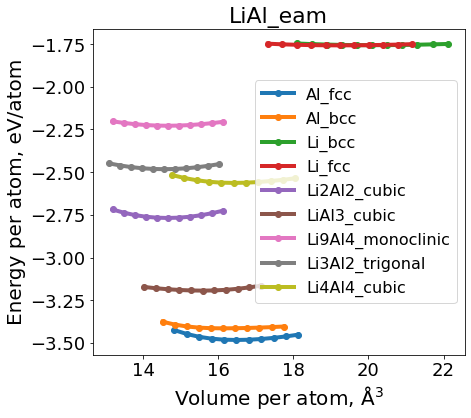

In [40]:
fig, ax_list = plt.subplots(ncols=len(potentials_list), nrows=1, sharex="row", sharey="row")

fig.set_figwidth(20/3)
fig.set_figheight(6)

color_palette = sns.color_palette("tab10", n_colors=len(data_murn.phase.unique()))


for i, pot in enumerate(potentials_list):
    
    if len(potentials_list) == 1:
        ax = ax_list
    else:
        ax = ax_list[i]
        
    data = data_murn[data_murn.potential == get_clean_project_name(pot)]
    
    for j,(_, row) in enumerate(data.iterrows()):
        murn_job = pr.load(row["job_id"])
        murn_df = murn_job.output_to_pandas()
        n_atoms = row["n_atoms"]
        
        ax.plot(murn_df["volume"]/n_atoms, murn_df["energy"]/n_atoms,"o-",
                lw=4,
                label= row["phase"], 
                color=color_palette[j])
        
    ax.set_title(f"{get_clean_project_name(pot)}",fontsize=22)
    ax.set_xlabel("Volume per atom, $\mathrm{\AA^3}$",fontsize=20)
    ax.set_ylabel("Energy per atom, eV/atom",fontsize=20)
    ax.tick_params(labelsize=18)
    ax.legend(prop={"size":16})
    #break
fig.subplots_adjust(wspace=0.1);

## (b) Elastic constants and Phonons

Pyiron also has job modules to calculate elastic constants and thermal properties using the quasi-harmonic approximation given by the `phonopy` package.

As in the previous task, we again loop over the defined potentials and then over the given structures.

Calculating elastic constants and thermal properties is considerably more expensive than calculating EV curves. Hence, it is useful to only calculate these properties for a subset of most important structures 

In [11]:
list_of_phases = ["Al_fcc","Li_bcc","Li2Al2_cubic","LiAl3_cubic"]

subset_murn = data_murn[data_murn["phase"].isin(list_of_phases)]
subset_murn

,job_id,potential,ase_atoms,compound,crystal_structure,a,eq_vol,eq_bm,eq_energy,n_atoms,phase
0,298,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.039967,16.495612,85.876912,-3.483097,1,Al_fcc
2,324,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,bcc,4.195477,20.114514,13.690609,-1.757011,1,Li_bcc
4,350,LiAl_eam,"(Atom('Li', [4.359978178265942, 2.5172345748814804, 1.7799536377360752], index=0), Atom('Li', [6.53996726740165, 3.7758518623203585, 2.669930456604318], index=1), Atom('Al', [-3.964456982410852e-1...",Li2Al2,cubic,6.165940,58.604895,100.347240,-11.074362,4,Li2Al2_cubic
5,363,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Al', [1.9825515172760235, 1.9825515172760237, 2.427925369776811e-16], index=1), Atom('Al', [1.9825515172760235, 1.2139626848884054e-16, 1.9825515172760...",LiAl3,cubic,5.607502,62.227580,51.472656,-12.774590,4,LiAl3_cubic


In [12]:
for pot in potentials_list:
    group_name = get_clean_project_name(pot)
    pr_pot = pr.create_group(group_name)
    print(group_name)
    
    for _, row in subset_murn[subset_murn.potential==group_name].iterrows():
        job_id = row["job_id"]
        
        job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, f"ref_job_{row.compound}_{row.crystal_structure}")
        ref = pr_pot.load(job_id)
        job_ref.structure = ref.structure
        job_ref.potential = pot
        job_ref.calc_minimize()
        elastic_job = job_ref.create_job(pr_pot.job_type.ElasticMatrixJob, f"elastic_job_{row.compound}_{row.crystal_structure}")
        elastic_job.input["eps_range"] = 0.05
        elastic_job.run()
        
        
        phonopy_job = job_ref.create_job(pr_pot.job_type.PhonopyJob, f"phonopy_job_{row.compound}_{row.crystal_structure}")
        job_ref.calc_static()
        phonopy_job.run()

LiAl_eam
The job elastic_job_Al_fcc was saved and received the ID: 414
The job s_e_0 was saved and received the ID: 415
The job s_01_e_m0_05000 was saved and received the ID: 416
The job s_01_e_m0_02500 was saved and received the ID: 417
The job s_01_e_0_02500 was saved and received the ID: 418
The job s_01_e_0_05000 was saved and received the ID: 419
The job s_08_e_m0_05000 was saved and received the ID: 420
The job s_08_e_m0_02500 was saved and received the ID: 421
The job s_08_e_0_02500 was saved and received the ID: 422
The job s_08_e_0_05000 was saved and received the ID: 423
The job s_23_e_m0_05000 was saved and received the ID: 424
The job s_23_e_m0_02500 was saved and received the ID: 425
The job s_23_e_0_02500 was saved and received the ID: 426
The job s_23_e_0_05000 was saved and received the ID: 427
The job phonopy_job_Al_fcc was saved and received the ID: 428
The job ref_job_Al_fcc_0 was saved and received the ID: 429
The job elastic_job_Li_bcc was saved and received the ID

In [13]:
def filter_elastic(job_table):
    return (job_table.hamilton == "ElasticMatrixJob") & (job_table.status == "finished")

# Get corresponding elastic constants
def get_c11(job_path):
    return job_path["output/elasticmatrix"]["C"][0, 0]

def get_c12(job_path):
    return job_path["output/elasticmatrix"]["C"][0, 1]

def get_c44(job_path):
    return job_path["output/elasticmatrix"]["C"][3, 3]

In [14]:
table = pr.create_table("table_elastic", delete_existing_job=True)
table.db_filter_function = filter_elastic
table.add["potential"] = get_potential
table.add["C11"] = get_c11
table.add["C12"] = get_c12
table.add["C44"] = get_c44
table.add["compound"] = get_compound
table.add["crystal_structure"] = get_crystal_structure

table.run()
data_elastic = table.get_dataframe()
data_elastic["phase"] = data_elastic.compound + "_" + data_elastic.crystal_structure
data_elastic = data_elastic[data_elastic["phase"].isin(list_of_phases)]
data_elastic

The job table_elastic was saved and received the ID: 480


Loading and filtering jobs:   0%|          | 0/4 [00:00<?, ?it/s]

Processing jobs:   0%|          | 0/4 [00:00<?, ?it/s]

,job_id,potential,C11,C12,C44,compound,crystal_structure,phase
0,414,LiAl_eam,120.339279,66.483631,45.515458,Al,fcc,Al_fcc
1,430,LiAl_eam,16.740018,11.018163,12.688217,Li,bcc,Li_bcc
2,446,LiAl_eam,179.464635,54.231219,47.889040,Li2Al2,cubic,Li2Al2_cubic
3,463,LiAl_eam,65.443987,47.601166,28.002138,LiAl3,cubic,LiAl3_cubic


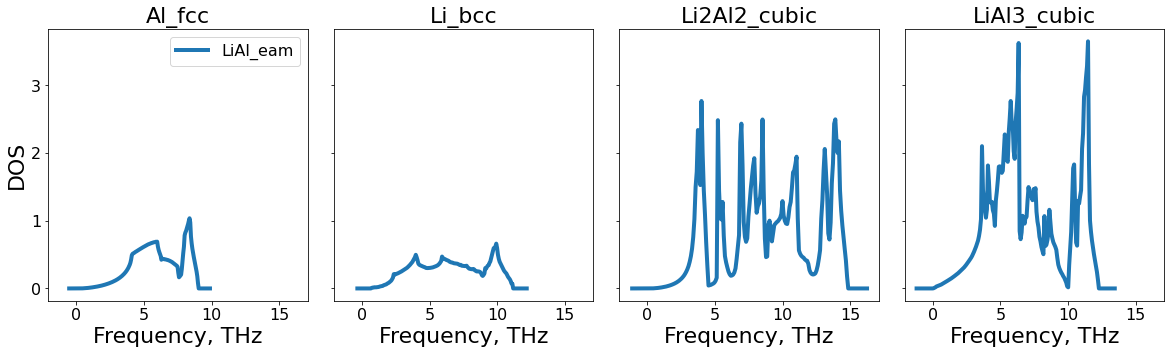

In [58]:
fig, ax_list = plt.subplots(ncols=len(data_elastic.phase.unique()), nrows=1, sharex="row", sharey="row")

fig.set_figwidth(20)
fig.set_figheight(5)

color_palette = sns.color_palette("tab10", n_colors=len(data_elastic.potential.unique()))


for i, phase in enumerate(data_elastic.phase.unique()):
    
    ax = ax_list[i]
    data = data_elastic[data_elastic.phase == phase]
    
    
    
    for j, pot in enumerate(potentials_list):
        
        phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]
    
        thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
        
        ax.plot(phonopy_job["output/dos_energies"], phonopy_job["output/dos_total"], 
                lw=4,
                color=color_palette[j], 
                label=get_clean_project_name(pot))
        ax.set_xlabel("Frequency, THz",fontsize=22)
    ax.set_title(f"{phase}",fontsize=22)
    ax.tick_params(labelsize=16)
ax_list[0].set_ylabel("DOS",fontsize=22)

ax_list[0].legend(prop={"size":16})
fig.subplots_adjust(wspace=0.1);

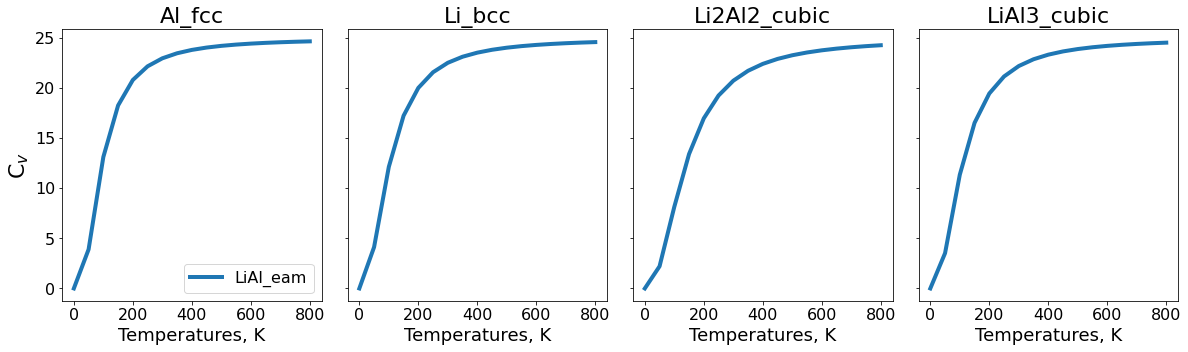

In [33]:
fig, ax_list = plt.subplots(ncols=len(data_elastic.phase.unique()), nrows=1, sharex="row", sharey="row")

fig.set_figwidth(20)
fig.set_figheight(5)

color_palette = sns.color_palette("tab10", n_colors=len(data_elastic.potential.unique()))


for i, phase in enumerate(data_elastic.phase.unique()):
    
    ax = ax_list[i]
    data = data_elastic[data_elastic.phase == phase]
    
    n_atom = data_murn[data_murn["phase"]==phase]["n_atoms"].item()
    
    
    for j, pot in enumerate(potentials_list):
        
        phonopy_job = pr[get_clean_project_name(pot) + f"/phonopy_job_{phase}"]
    
        thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)

        ax.plot(thermo.temperatures, thermo.cv/n_atom,
                lw=4,
                label=get_clean_project_name(pot), 
                color=color_palette[j])
        ax.set_xlabel("Temperatures, K",fontsize=18)
    ax.set_title(f"{phase}",fontsize=22)
    ax.tick_params(labelsize=16)
ax_list[0].set_ylabel("C$_v$",fontsize=22)

ax_list[0].legend(prop={"size":16})
fig.subplots_adjust(wspace=0.1);

In [17]:
# phonopy_job.plot_band_structure()

### (c) Convex hull

To assess the stability of the binary phases, we plot a convex hull for the considered phases. 

For this task we compute the formation energies of the mixed phases relative to ground state energies of equilibrium unary phases.

In [41]:
from collections import Counter

data_convexhull = data_murn.copy()
data_convexhull.head(2)

,job_id,potential,ase_atoms,compound,crystal_structure,a,eq_vol,eq_bm,eq_energy,n_atoms,phase
0,298,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.039967,16.495612,85.876912,-3.483097,1,Al_fcc
1,311,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,bcc,3.898853,16.147864,48.620841,-3.415312,1,Al_bcc


Using `Collections.counter` we construct a composition dictionary for all the phases and from that dictionary, we can extract the relative concentrations of Al and Li in each structure

In [42]:
data_convexhull["comp_dict"] = data_convexhull["ase_atoms"].map(lambda at: Counter(at.get_chemical_symbols()))
data_convexhull["n_Al"] = data_convexhull["comp_dict"].map(lambda d: d.get("Al",0))
data_convexhull["n_Li"] = data_convexhull["comp_dict"].map(lambda d: d.get("Li",0))

data_convexhull["cAl"]=data_convexhull["n_Al"]/data_convexhull["n_atoms"]
data_convexhull["cLi"]=data_convexhull["n_Li"]/data_convexhull["n_atoms"]

data_convexhull

,job_id,potential,ase_atoms,compound,crystal_structure,a,eq_vol,eq_bm,eq_energy,n_atoms,phase,comp_dict,n_Al,n_Li,cAl,cLi
0,298,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.039967,16.495612,85.876912,-3.483097,1,Al_fcc,{'Al': 1},1,0,1.000000,0.000000
1,311,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,bcc,3.898853,16.147864,48.620841,-3.415312,1,Al_bcc,{'Al': 1},1,0,1.000000,0.000000
2,324,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,bcc,4.195477,20.114514,13.690609,-1.757011,1,Li_bcc,{'Li': 1},0,1,0.000000,1.000000
3,337,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,fcc,4.253841,19.241330,13.985972,-1.758107,1,Li_fcc,{'Li': 1},0,1,0.000000,1.000000
4,350,LiAl_eam,"(Atom('Li', [4.359978178265942, 2.5172345748814804, 1.7799536377360752], index=0), Atom('Li', [6.53996726740165, 3.7758518623203585, 2.669930456604318], index=1), Atom('Al', [-3.964456982410852e-1...",Li2Al2,cubic,6.165940,58.604895,100.347240,-11.074362,4,Li2Al2_cubic,"{'Li': 2, 'Al': 2}",2,2,0.500000,0.500000
5,363,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Al', [1.9825515172760235, 1.9825515172760237, 2.427925369776811e-16], index=1), Atom('Al', [1.9825515172760235, 1.2139626848884054e-16, 1.9825515172760...",LiAl3,cubic,5.607502,62.227580,51.472656,-12.774590,4,LiAl3_cubic,"{'Li': 1, 'Al': 3}",3,1,0.750000,0.250000
6,376,LiAl_eam,"(Atom('Li', [4.9874675377354745, 1.0099032069001204, 0.8188717268019969], index=0), Atom('Li', [3.1237856900347722, 1.4557299809760758, 2.6737242758835587], index=1), Atom('Li', [-3.44219970899484...",Li9Al4,monoclinic,13.023702,190.504371,53.125273,-28.970054,13,Li9Al4_monoclinic,"{'Li': 9, 'Al': 4}",4,9,0.307692,0.692308
7,389,LiAl_eam,"(Atom('Al', [2.1548001975659243, 1.2440753587819189, 1.8617841750008692], index=0), Atom('Al', [-2.154798282819334, 3.7322233132135576, 2.664676023808053], index=1), Atom('Li', [8.560563403365655e...",Li3Al2,trigonal,6.094693,72.810229,69.231669,-12.413856,5,Li3Al2_trigonal,"{'Al': 2, 'Li': 3}",2,3,0.400000,0.600000
8,490,LiAl_eam,"(Atom('Li', [2.1429671662366734, 1.237242669260901, 7.662122465542487], index=0), Atom('Li', [-8.827603092953495e-10, 2.4744853400282523, 0.5913662557792814], index=1), Atom('Li', [-8.827603092953...",Li4Al4,cubic,6.061226,131.389799,71.221356,-20.506570,8,Li4Al4_cubic,"{'Li': 4, 'Al': 4}",4,4,0.500000,0.500000


Obtain the equilibrium energies for unary Al and Li phases from the Dataframe

In [43]:
E_f_Al = data_convexhull.loc[data_convexhull["n_Li"]==0,"eq_energy"].min()
E_f_Li = data_convexhull.loc[data_convexhull["n_Al"]==0,"eq_energy"].min()

[E_f_Al, E_f_Li]

[-3.4830968311997523, -1.758107337432567]

Calculate the relative formation energies by subtracting the total energies of the mixed phases with the energies of eq Al and Li

$$E^{A_xB_y}_{f} = E_{A_xB_y} - (x E_A + yE_B)$$

In [44]:
data_convexhull["E_form"]=(data_convexhull["eq_energy"])-(data_convexhull[["n_Al","n_Li"]].values * [E_f_Al, E_f_Li]).sum(axis=1)
data_convexhull["E_form_per_atom"] = data_convexhull["E_form"]/data_convexhull["n_atoms"]

data_convexhull = data_convexhull.sort_values("cLi")

data_convexhull

,job_id,potential,ase_atoms,compound,crystal_structure,a,eq_vol,eq_bm,eq_energy,n_atoms,phase,comp_dict,n_Al,n_Li,cAl,cLi,E_form,E_form_per_atom
0,298,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,fcc,4.039967,16.495612,85.876912,-3.483097,1,Al_fcc,{'Al': 1},1,0,1.000000,0.000000,0.000000,0.000000
1,311,LiAl_eam,"(Atom('Al', [0.0, 0.0, 0.0], index=0))",Al,bcc,3.898853,16.147864,48.620841,-3.415312,1,Al_bcc,{'Al': 1},1,0,1.000000,0.000000,0.067785,0.067785
5,363,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0), Atom('Al', [1.9825515172760235, 1.9825515172760237, 2.427925369776811e-16], index=1), Atom('Al', [1.9825515172760235, 1.2139626848884054e-16, 1.9825515172760...",LiAl3,cubic,5.607502,62.227580,51.472656,-12.774590,4,LiAl3_cubic,"{'Li': 1, 'Al': 3}",3,1,0.750000,0.250000,-0.567192,-0.141798
4,350,LiAl_eam,"(Atom('Li', [4.359978178265942, 2.5172345748814804, 1.7799536377360752], index=0), Atom('Li', [6.53996726740165, 3.7758518623203585, 2.669930456604318], index=1), Atom('Al', [-3.964456982410852e-1...",Li2Al2,cubic,6.165940,58.604895,100.347240,-11.074362,4,Li2Al2_cubic,"{'Li': 2, 'Al': 2}",2,2,0.500000,0.500000,-0.591954,-0.147988
8,490,LiAl_eam,"(Atom('Li', [2.1429671662366734, 1.237242669260901, 7.662122465542487], index=0), Atom('Li', [-8.827603092953495e-10, 2.4744853400282523, 0.5913662557792814], index=1), Atom('Li', [-8.827603092953...",Li4Al4,cubic,6.061226,131.389799,71.221356,-20.506570,8,Li4Al4_cubic,"{'Li': 4, 'Al': 4}",4,4,0.500000,0.500000,0.458247,0.057281
7,389,LiAl_eam,"(Atom('Al', [2.1548001975659243, 1.2440753587819189, 1.8617841750008692], index=0), Atom('Al', [-2.154798282819334, 3.7322233132135576, 2.664676023808053], index=1), Atom('Li', [8.560563403365655e...",Li3Al2,trigonal,6.094693,72.810229,69.231669,-12.413856,5,Li3Al2_trigonal,"{'Al': 2, 'Li': 3}",2,3,0.400000,0.600000,-0.173341,-0.034668
6,376,LiAl_eam,"(Atom('Li', [4.9874675377354745, 1.0099032069001204, 0.8188717268019969], index=0), Atom('Li', [3.1237856900347722, 1.4557299809760758, 2.6737242758835587], index=1), Atom('Li', [-3.44219970899484...",Li9Al4,monoclinic,13.023702,190.504371,53.125273,-28.970054,13,Li9Al4_monoclinic,"{'Li': 9, 'Al': 4}",4,9,0.307692,0.692308,0.785300,0.060408
2,324,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,bcc,4.195477,20.114514,13.690609,-1.757011,1,Li_bcc,{'Li': 1},0,1,0.000000,1.000000,0.001096,0.001096
3,337,LiAl_eam,"(Atom('Li', [0.0, 0.0, 0.0], index=0))",Li,fcc,4.253841,19.241330,13.985972,-1.758107,1,Li_fcc,{'Li': 1},0,1,0.000000,1.000000,0.000000,0.000000


In [46]:
subset_covexhull = data_convexhull[data_convexhull["phase"].isin(["Al_fcc","LiAl3_cubic","Li2Al2_cubic","Li_bcc"])]

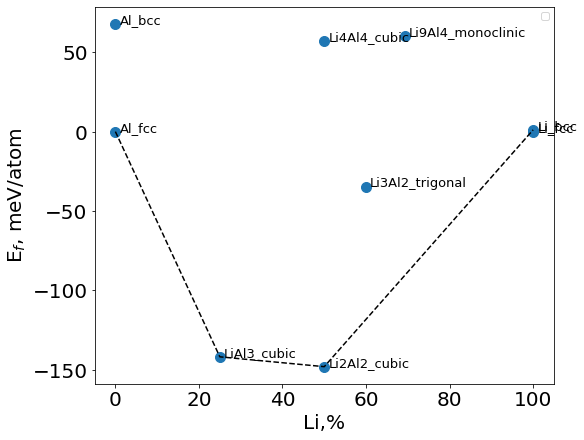

In [56]:
fig,ax = plt.subplots(figsize=(8,6),constrained_layout=True)

ax.plot(data_convexhull["cLi"]*100, data_convexhull["E_form_per_atom"]*1e3,"o",markersize=10)

# ax.axhline(0,ls="--",color="k")
ax.plot(subset_covexhull["cLi"]*100, subset_covexhull["E_form_per_atom"]*1e3,"--",color="k",markersize=20)
ax.legend()
ax.set_xlabel("Li,%",fontsize="20")
ax.set_ylabel("E$_f$, meV/atom",fontsize="20")
ax.tick_params(labelsize=20,axis="both")
# plt.savefig("Convexhull")

for _,row in data_convexhull.iterrows():
    plt.text((row["cLi"]+0.01)*100,row["E_form_per_atom"]*1e3,row["phase"],size=13)

plt.show()

In [24]:
time_stop = time.process_time()
print(f"Total run time for the notebook {time_stop - time_start} seconds")

Total run time for the notebook 194.79580644700002 seconds


In [25]:
194.79580644700002/60

3.246596774116667